In [6]:
#conditional operators 
# ==, !=, >, <, >=, <=
condition1 = (2>1)
print(condition1)
condition2 = (2<=1)
print(condition2)
condition3 = (2!=1)
print(condition3)
condition4 = (5==5)
print(condition4)

True
False
True
True


In [14]:
value1 = input('Enter a number from 1 to 100: ')
value2 = int(value1)
if (value2 < 1):
    print('you have entered a value less than 1')
elif (value2 > 100):
    print('you have entered a value greater than 100')
elif (value2 == 99):
    print('you have guessed my favorite number')
else:
    print('you have not guessed my favorite number, try again next time...')

you have guessed my favorite number


In [ ]:
userName = input('Username: ')
password = input('Password: ')
if(userName=='Enzo' and password=='compro'):
    otpCode = input('Enter your OTP code')
    if (otpCode =='ABCD123'):
        print ('Welcome Enzo')
        #this is where you write your continuing codes
    else:
        print('Invalid OTP Code')
else:
    print('Invalid Username or Password')

Welcome Enzo


In [ ]:
usernames = ['Enzo', 'Oca','Martin','Eldrei']
passwords = ['compro1','compro2','compro3','compro4']

userName = input('Username: ')
password = input('Password: ')

if(userName in usernames):
    if(password == passwords[usernames.index(userName)]):
        otpCode = ['ABC123']
        print('Welcome User')
    else:
        print('Invalid Password')
else:
    print('Invalid Username')

Invalid Password


In [28]:
passwords = ['compro1','compro2','compro3','compro4']
print(passwords.index('compro1'))
print(passwords[passwords.index('compro1')])

0
compro1


In [ ]:
import fitz  # PyMuPDF
from pymongo import MongoClient
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langchain.schema import Document
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import OpenAI
from langchain.schema.retriever import BaseRetriever
from typing import List
import tqdm as notebook_tqdm
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage

# === CONFIGURATION ===
PDF_FILE = "example.pdf"
EMBED_MODEL = "all-MiniLM-L6-v2"

# LM Studio (Local Server) Settings
LM_STUDIO_BASE = "http://localhost:1234/v1"
LM_STUDIO_MODEL = "TheBloke_Mistral-7B-Instruct-v0.1-GGUF"  # Replace with exact name from LM Studio's /models

# MongoDB Settings
client = MongoClient("mongodb://localhost:27017/")
db = client["vector_db"]
collection = db["pdf_chunks"]

# Embedder
embedder = SentenceTransformer(EMBED_MODEL)


# === FUNCTIONS ===

def extract_text_from_pdf(path):
    text = ""
    doc = fitz.open(path)
    for page in doc:
        text += page.get_text()
    return text


def split_text(text, chunk_size=500, overlap=50):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks


def store_embeddings(chunks):
    for chunk in chunks:
        embedding = embedder.encode(chunk).tolist()
        collection.insert_one({
            "text": chunk,
            "embedding": embedding
        })


# === CUSTOM MONGODB RETRIEVER COMPATIBLE WITH LANGCHAIN ===

class MongoDBRetriever(BaseRetriever):
    def __init__(self, collection, embedder, k=3):
        super().__init__()
        object.__setattr__(self, "collection", collection)
        object.__setattr__(self, "embedder", embedder)
        object.__setattr__(self, "k", k)

    def get_relevant_documents(self, query: str) -> List[Document]:
        query_embedding = self.embedder.encode(query)
        all_docs = list(self.collection.find({}))

        similarities = []
        for doc in all_docs:
            score = cosine_similarity([query_embedding], [doc['embedding']])[0][0]
            similarities.append((score, doc['text']))

        top_chunks = sorted(similarities, key=lambda x: x[0], reverse=True)[:self.k]
        return [Document(page_content=chunk) for _, chunk in top_chunks]

    async def aget_relevant_documents(self, query: str) -> List[Document]:
        return self.get_relevant_documents(query)


# === LM STUDIO LLM WRAPPER ===

def get_llm():
    return ChatOpenAI(
        openai_api_base=LM_STUDIO_BASE,
        openai_api_key="lm-studio",  # Dummy value required
        model=LM_STUDIO_MODEL,
        temperature=0.7
    )


# === MAIN PROGRAM ===

if __name__ == "__main__":
    if collection.count_documents({}) == 0:
        print("[*] Indexing PDF into MongoDB vector store...")
        text = extract_text_from_pdf(PDF_FILE)
        chunks = split_text(text)
        store_embeddings(chunks)
        print("[✓] Embeddings stored.")

    retriever = MongoDBRetriever(collection=collection, embedder=embedder, k=3)
    memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

    qa_chain = ConversationalRetrievalChain.from_llm(
        llm=get_llm(),
        retriever=retriever,
        memory=memory,
        verbose=True
    )

    print("\n🧠 Chat with your PDF! (type 'exit' to quit)\n")
    while True:
        query = input("You: ")
        if query.lower() in ['exit', 'quit']:
            print("👋 Goodbye!")
            break
        try:
            result = qa_chain.run(query)
            print("Assistant:", result)
        except Exception as e:
            print("❌ Error:", e)


c:\Users\oscar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🧠 Chat with your PDF! (type 'exit' to quit)



c:\Users\oscar\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
with sub-directories for each chapter. You can make the directory structure by running the following commands in the home directory of the pi user: mkdir book mkdir book/dataset mkdir book/chapter01 We can make a separate directory for each chapter like this. Also, a separate dataset directory to store our data is needed. After creating the prescribed directory structure, run the following sequence of commands: cd book tree We can see the directory structure in the following output of the tree command: Figure 3.7 – Directory structure for saving programs for this book 58 Introduction to Python Programming We can create the same directory structure by using the Save dialog box of IDLE or the File Mana

In [3]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage

# Initialize LM Studio chat model
llm = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    api_key="lm-studio",  # Dummy value
    #model="TheBloke_Mistral-7B-Instruct-v0.1-GGUF",  # Make sure this matches your LM Studio model ID
    temperature=0.7,
)

try:
    # Using proper chat message object
    response = llm([HumanMessage(content="can you create a simple python code of Hello World for raspberry pi")])
    print("✅ Response:", response.content)
except Exception as e:
    print("❌ ERROR:", e)


✅ Response: Sure, here is a simple Python program that prints "Hello, World!" to the console. 

```python
print("Hello, World")
```

To run this on Raspberry Pi, open your terminal and type in `python3 filename.py` (replace `filename.py` with the name you used for your python file). This will execute the program and print "Hello, World" to the console. 

Please note that Python might not be installed by default on Raspbian or other Linux distributions like Ubuntu. You can install it using this command: `sudo apt-get install python3`. If you don't have Python installed, you should consider doing so as it is a necessary part of the operating system and many of your programs will not work without it.



In [1]:
import os

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain.chains import create_retrieval_chain
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import MessagesPlaceholder
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain_community.document_loaders import PyPDFLoader

In [ ]:
!pip install -r requirements.txt



In [ ]:
def load_pdf_documents(file_path):
    loader = PyPDFLoader(file_path)
    documents = loader.load()
    return documents

def split_documents(documents):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=400,
        chunk_overlap=20
    )
    return splitter.split_documents(documents)

def create_db(docs, db_file):
    embedding = OpenAIEmbeddings(
        openai_api_base="http://localhost:1234/v1",
        api_key="lm-studio",
        check_embedding_ctx_length=False
    )
    vector_store = FAISS.from_documents(docs, embedding=embedding)

    # Save the vector store to a folder
    vector_store.save_local(db_file)

    return vector_store

def create_or_append_db(docs, db_file):
    embedding = OpenAIEmbeddings(
        openai_api_base="http://localhost:1234/v1",
        api_key="lm-studio",
        check_embedding_ctx_length=False
    )
    if os.path.exists(db_file):
        print("Appending to existing vector store...")
        vector_store = FAISS.load_local(db_file, embedding, allow_dangerous_deserialization=True)
        vector_store.add_documents(docs)
    else:
        print("Creating a new vector store...")
        vector_store = FAISS.from_documents(docs, embedding=embedding)
    
    vector_store.save_local(db_file)
    return vector_store

def load_db(db_file):
    # Load the vector store from a folder
    embedding = OpenAIEmbeddings(
        openai_api_base="http://localhost:1234/v1",
        api_key="lm-studio",
        check_embedding_ctx_length=False
    )
    return FAISS.load_local(db_file, embedding, allow_dangerous_deserialization=True)

def create_chain(vector_store):
    model = ChatOpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio", temperature=0)
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are an expert in embedded systems programming using Arduino and Raspberry Pi.\n"
         "Use the following contextual information to answer the user’s request.\n"
         "Generate a single, functional code example based on the user’s instructions.\n"
         "Use either Arduino C++ or Python as appropriate.\n"
         "Do not include any explanations, just the code block.\n"
         "Context: {context}"),
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}")
    ])
    chain = create_stuff_documents_chain(
        llm=model,
        prompt=prompt
    )
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    retriever_prompt = ChatPromptTemplate.from_messages([
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}"),
        ("user", "Given the above conversation, generate a search query to look up in order to get information relevant to the conversation")
    ])
    history_aware_retriever = create_history_aware_retriever(
        llm=model,
        retriever=retriever,
        prompt=retriever_prompt
    )
    retrieval_chain = create_retrieval_chain(history_aware_retriever, chain)
    return retrieval_chain

def process_chat(chain, question, chat_history):
    response = chain.invoke({
        "input": question,
        "chat_history": chat_history
    })
    return response["answer"]

In [1]:
!pip install numpy matplotlib


DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\jwcrypto-1.5.6-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\redis-6.2.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\websockify-0.13.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
n = np.arange(-5,6)
x = np.array([0, 5, 6 ,7,9,0,0, -5, -9, -7, -6])
print(n)
print(x)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
[ 0  5  6  7  9  0  0 -5 -9 -7 -6]


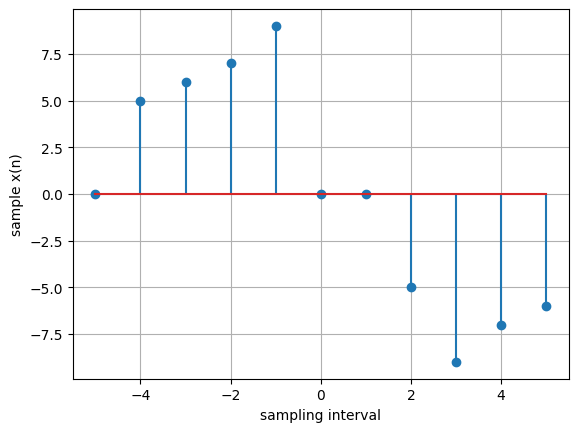

In [10]:
plt.stem(n,x)
plt.xlabel('sampling interval')
plt.ylabel('sample x(n)')
plt.grid(True)
plt.show()

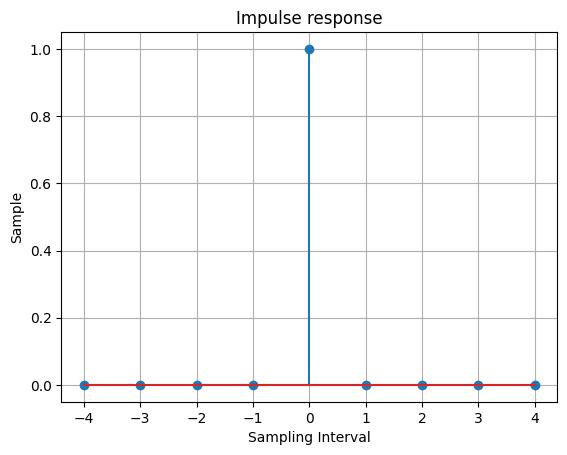

In [11]:
n = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
xn = ([ 0, 0, 0, 0, 1, 0, 0, 0, 0])
plt.stem(n,xn)
plt.title('Impulse response')
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

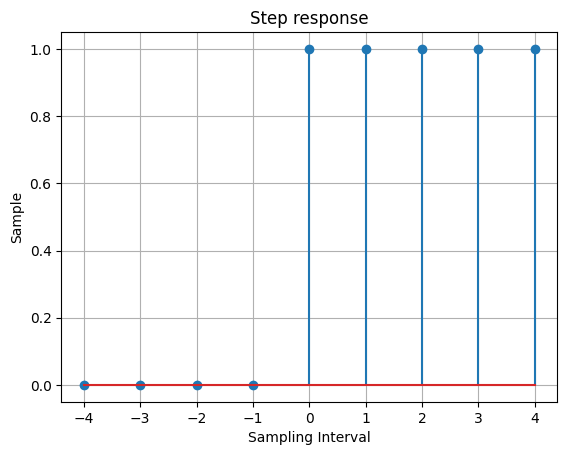

In [12]:
n = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
xn = ([ 0, 0, 0, 0, 1, 1, 1, 1, 1])
plt.stem(n,xn)
plt.title('Step response')
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

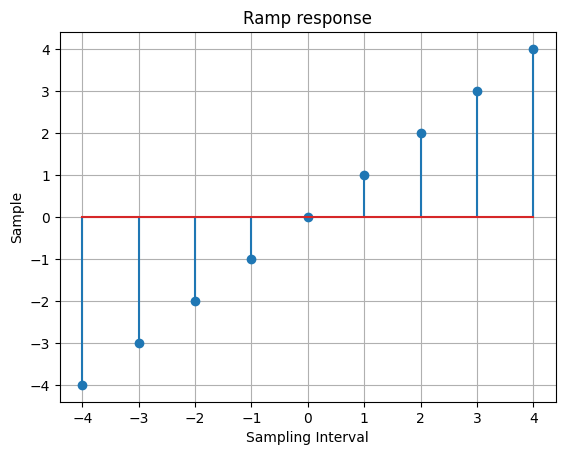

In [14]:
n = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
xn = ([-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.stem(n,xn)
plt.title('Ramp response')
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

In [15]:
!pip list

Package                   Version
------------------------- -----------
aiohappyeyeballs          2.4.4
aiohttp                   3.11.11
aiosignal                 1.3.2
altair                    5.5.0
annotated-types           0.7.0
anyio                     4.9.0
asttokens                 3.0.0
attrs                     24.3.0
autocommand               2.2.2
backports.tarfile         1.2.0
bcrypt                    4.2.1
beautifulsoup4            4.12.3
blinker                   1.9.0
cachetools                5.5.0
certifi                   2024.12.14
cffi                      1.17.1
charset-normalizer        3.4.1
click                     8.1.8
colorama                  0.4.6
comm                      0.2.2
comtypes                  1.4.10
contourpy                 1.3.1
control                   0.10.1
cryptography              44.0.0
cycler                    0.12.1
dataclasses-json          0.6.7
debugpy                   1.8.11
decorator                 5.1.1
distro           

DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\jwcrypto-1.5.6-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\redis-6.2.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\websockify-0.13.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [16]:
!pip install opencv-python-headless

DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\jwcrypto-1.5.6-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\redis-6.2.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\oscar\appdata\local\programs\python\python312\lib\site-packages\websockify-0.13.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 2

Image width: 5360px
Image height: 3560px
Number of channels: 3


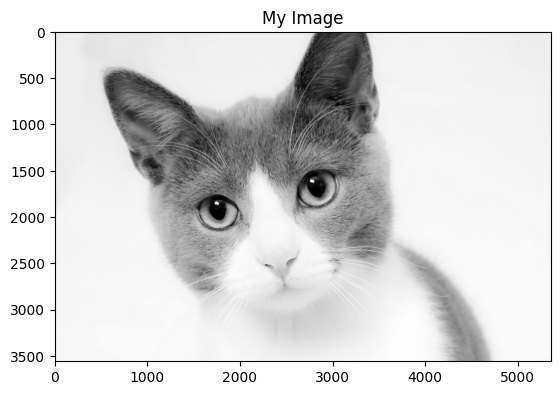

In [8]:
import cv2 
import matplotlib.pyplot as plt

# Load an image (change 'image.jpg' to your image file path)
image = cv2.imread('image.jpg')

# Check if the image was loaded properly
if image is None:
    print("Error: Could not load image.")
else:
    # Get the size of the image
    height, width, channels = image.shape #[rows, columns, rbg--> [r,g,b]]
    print(f"Image width: {width}px")
    print(f"Image height: {height}px")
    print(f"Number of channels: {channels}")

    # Show the image in a window
    
    image_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.cvtColor(image_g, cv2.COLOR_BGR2RGB)

    # Show the image in the notebook
    plt.imshow(image_gray)
    plt.title("My Image")
    plt.axis('on')  # You can use 'off' to hide axes
    plt.show()


In [17]:
import copy

original = [[1, 2], [3, 4]]
shallow = copy.copy(original)

shallow[0][0] = 99
print(original)  # [[99, 2], [3, 4]]

[[99, 2], [3, 4]]


In [19]:
original = [[1, 2], [3, 4]]
deep = copy.deepcopy(original)

In [20]:
deep[0][0] = 99
print(original)
print(deep)

[[1, 2], [3, 4]]
[[99, 2], [3, 4]]


Detected objects: 20


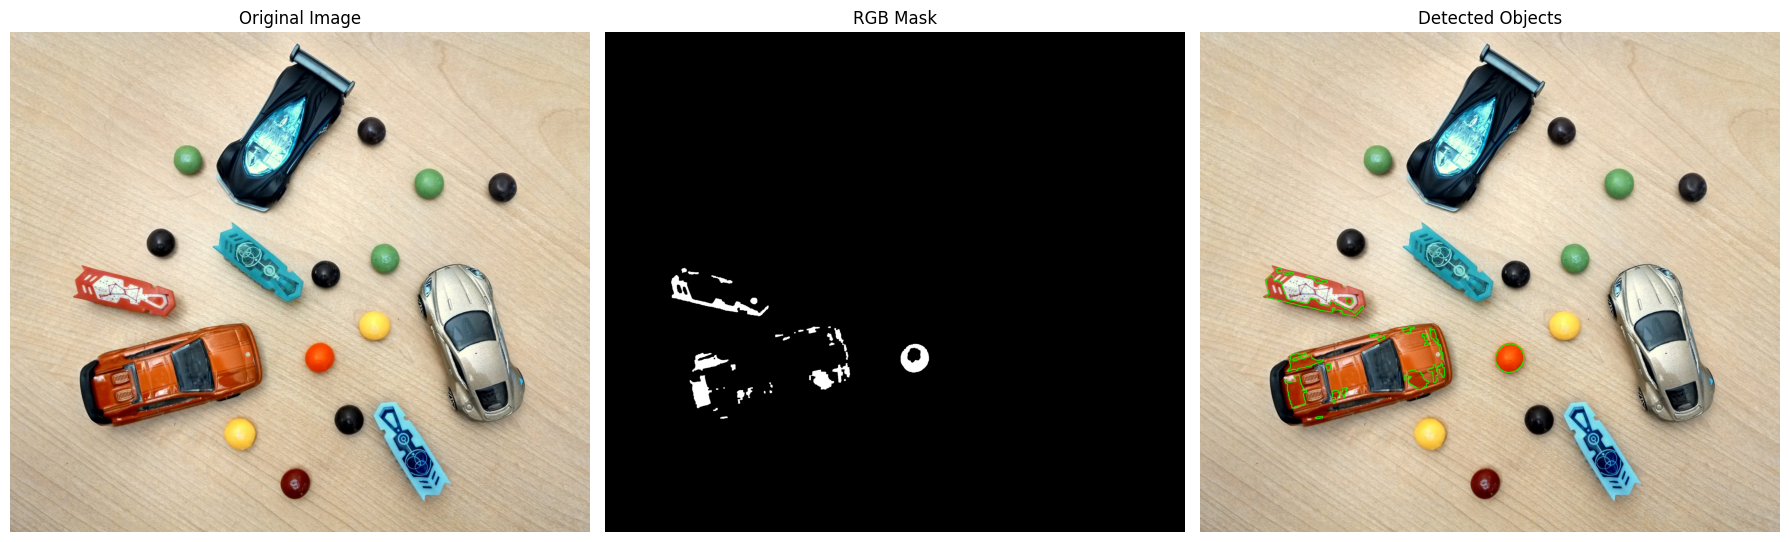

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (replace with your own image path)
image = cv2.imread('toys.jpg')  # Make sure the image is in your working directory
if image is None:
    print("Error: Could not load image.")
else:
    # Convert to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define RGB color range (example: red objects)
    lower_rgb = np.array([150, 0, 0])
    upper_rgb = np.array([255, 80, 80])

    # Create mask
    mask = cv2.inRange(rgb_image, lower_rgb, upper_rgb)

    # Clean up mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    output_image = rgb_image.copy()
    count = 0
    for contour in contours:
        if cv2.contourArea(contour) > 100:
            count += 1
            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)

    print(f"Detected objects: {count}")

    # Plotting images inline
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(rgb_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask_cleaned, cmap='gray')
    axs[1].set_title("RGB Mask")
    axs[1].axis('off')

    axs[2].imshow(output_image)
    axs[2].set_title("Detected Objects")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install scikit-image 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening
from skimage.util import invert

# Load image
image = cv2.imread('toys.jpg')
if image is None:
    raise FileNotFoundError("Image not found.")

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract channels
rmat = image_rgb[:, :, 0]
gmat = image_rgb[:, :, 1]
bmat = image_rgb[:, :, 2]

# Threshold levels
levelr = 0.5 * 255
levelg = 0.45 * 255
levelb = 0.5 * 255

# Threshold RGB channels
Ired = (rmat > levelr).astype(np.uint8)
Igreen = (gmat > levelg).astype(np.uint8)
Iblue = (bmat > levelb).astype(np.uint8)

# Combine channels
It = cv2.bitwise_and(cv2.bitwise_and(Ired, Igreen), Iblue)

# Invert mask
Icomp = cv2.bitwise_not(It * 255)

# Fill holes
flood_fill = Icomp.copy()
h, w = flood_fill.shape
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(flood_fill, mask, (0, 0), 255)
filled = cv2.bitwise_or(Icomp, cv2.bitwise_not(flood_fill))

# Morphological open
opened = opening(filled // 255, disk(25)).astype(np.uint8)

# Label connected components
label_image = label(opened)
regions = regionprops(label_image)

###
for region in regions:
        area = region.area
        centroid = region.centroid
        print(area)

# Classify objects
small, medium, large = [], [], []
for region in regions:
    area = region.area
    if area < 14000:
        small.append(region)
    elif area < 45000:
        medium.append(region)
    else:
        large.append(region)

# Draw boxes on copy of image
output_img = image_rgb.copy()
for region in small:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
    cv2.putText(output_img, 'P1', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

for region in medium:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    cv2.putText(output_img, 'P5', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

for region in large:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
    cv2.putText(output_img, 'P20', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

# Display results side-by-side
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axs[0, 0].imshow(image_rgb)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

axs[0, 1].imshow(It, cmap='gray')
axs[0, 1].set_title("Combined RGB Threshold (It)")
axs[0, 1].axis("off")

axs[0, 2].imshow(Icomp, cmap='gray')
axs[0, 2].set_title("Complemented Mask (Icomp)")
axs[0, 2].axis("off")

axs[1, 0].imshow(filled, cmap='gray')
axs[1, 0].set_title("Holes Filled")
axs[1, 0].axis("off")

axs[1, 1].imshow(opened, cmap='gray')
axs[1, 1].set_title("Opened (Cleaned Binary)")
axs[1, 1].axis("off")

axs[1, 2].imshow(output_img)
axs[1, 2].set_title("Final Detected Object")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

# Display total value
total_value = len(small)  + len(medium)  + len(large) 
print(f"small: {len(small)}")
print(f"medium: {len(medium)}")
print(f"large: {len(large)}")
print(f"count: {total_value}")


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening
from skimage.util import invert

# Load image
image = cv2.imread('toys.jpg')
if image is None:
    raise FileNotFoundError("Image not found.")

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# Extract channels
rmat = image_rgb[:, :, 0]
gmat = image_rgb[:, :, 1]
bmat = image_rgb[:, :, 2]
#show image for each channel
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
axs[0].imshow(rmat)
axs[0].set_title("red channel")
axs[0].axis("off")

axs[1].imshow(gmat)
axs[1].set_title("green channel")
axs[1].axis("off")

axs[2].imshow(bmat)
axs[2].set_title("blue channel")
axs[2].axis("off")

plt.tight_layout()
plt.show()

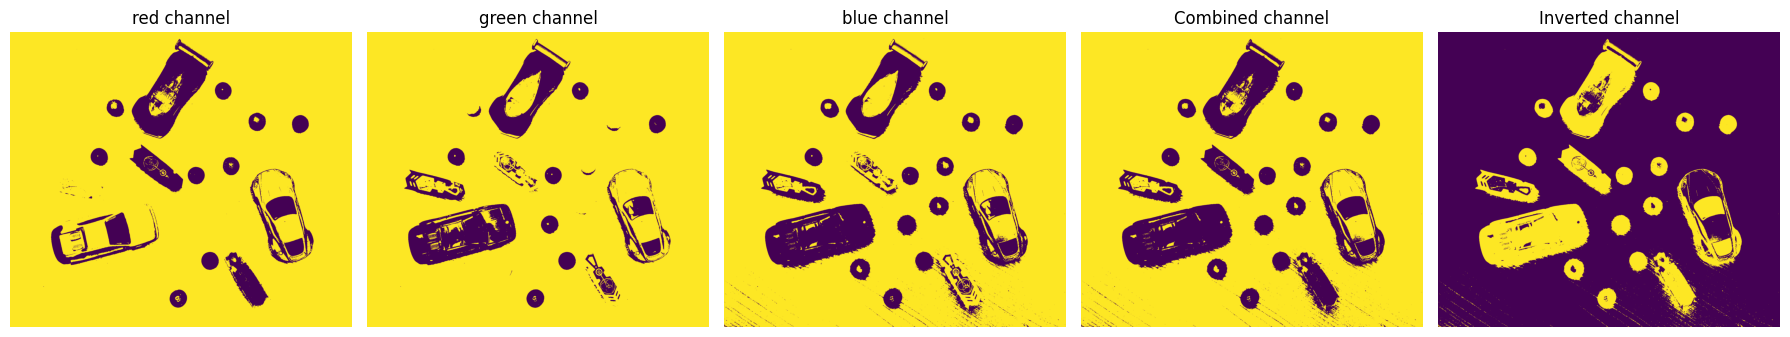

In [71]:
# Threshold levels
levelr = 0.5 * 255
levelg = 0.45 * 255
levelb = 0.5 * 255

# Threshold RGB channels
Ired = (rmat > levelr).astype(np.uint8)
Igreen = (gmat > levelg).astype(np.uint8)
Iblue = (bmat > levelb).astype(np.uint8)

# Combine channels
It = cv2.bitwise_and(cv2.bitwise_and(Ired, Igreen), Iblue)

# Invert mask
Icomp = cv2.bitwise_not(It * 255)

#show image for each channel
fig, axs = plt.subplots(1, 5, figsize=(18, 12))
axs[0].imshow(Ired)
axs[0].set_title("red channel")
axs[0].axis("off")

axs[1].imshow(Igreen)
axs[1].set_title("green channel")
axs[1].axis("off")

axs[2].imshow(Iblue)
axs[2].set_title("blue channel")
axs[2].axis("off")

axs[3].imshow(It)
axs[3].set_title("Combined channel")
axs[3].axis("off")

axs[4].imshow(Icomp)
axs[4].set_title("Inverted channel")
axs[4].axis("off")

plt.tight_layout()
plt.show()

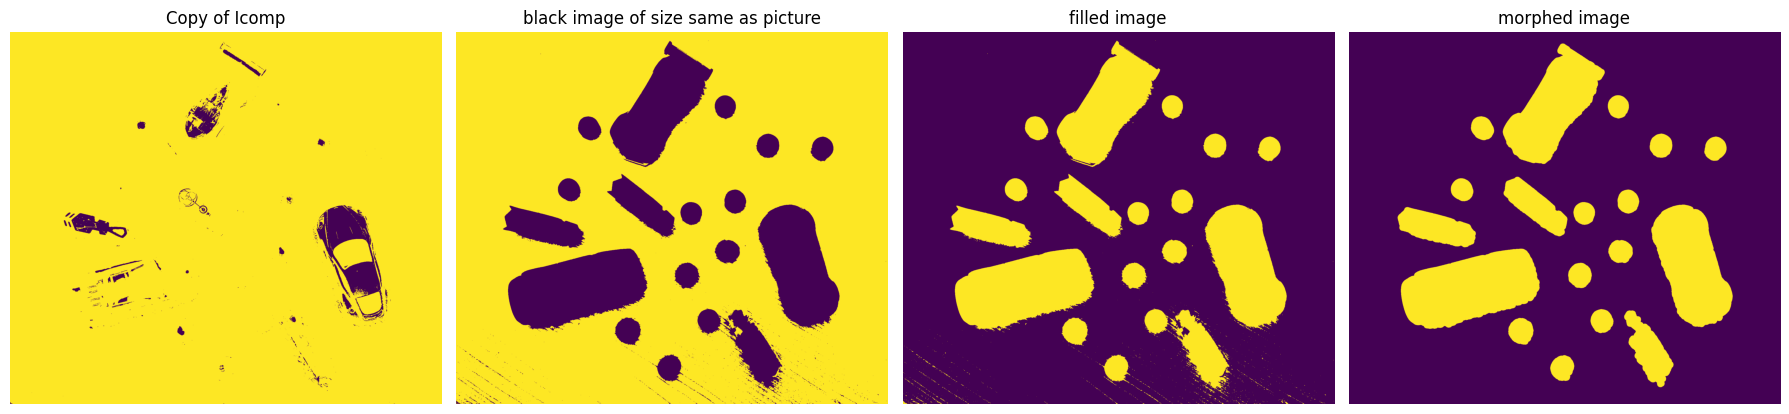

134840.0
8612.0
9442.0
9652.0
9227.0
39089.0
8935.0
9158.0
8660.0
141986.0
43383.0
10058.0
172051.0
10364.0
9452.0
40073.0
11664.0
10612.0


In [ ]:
# Fill holes
flood_fill = Icomp.copy()
h, w = flood_fill.shape
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(flood_fill, mask, (0, 0), 255)
filled = cv2.bitwise_or(Icomp, cv2.bitwise_not(flood_fill))

# Morphological open
opened = opening(filled // 255, disk(15)).astype(np.uint8)

# Label connected components
label_image = label(opened)
regions = regionprops(label_image)

#show image for each channel
fig, axs = plt.subplots(1, 4, figsize=(18, 12))
axs[0].imshow(flood_fill)
axs[0].set_title("Copy of Icomp")
axs[0].axis("off")

axs[1].imshow(mask)
axs[1].set_title("black image of size same as picture")
axs[1].axis("off")

axs[2].imshow(filled)
axs[2].set_title("filled image")
axs[2].axis("off")

axs[3].imshow(opened)
axs[3].set_title("morphed image")
axs[3].axis("off")


plt.tight_layout()
plt.show()
###
for region in regions:
        area = region.area
        print(area)

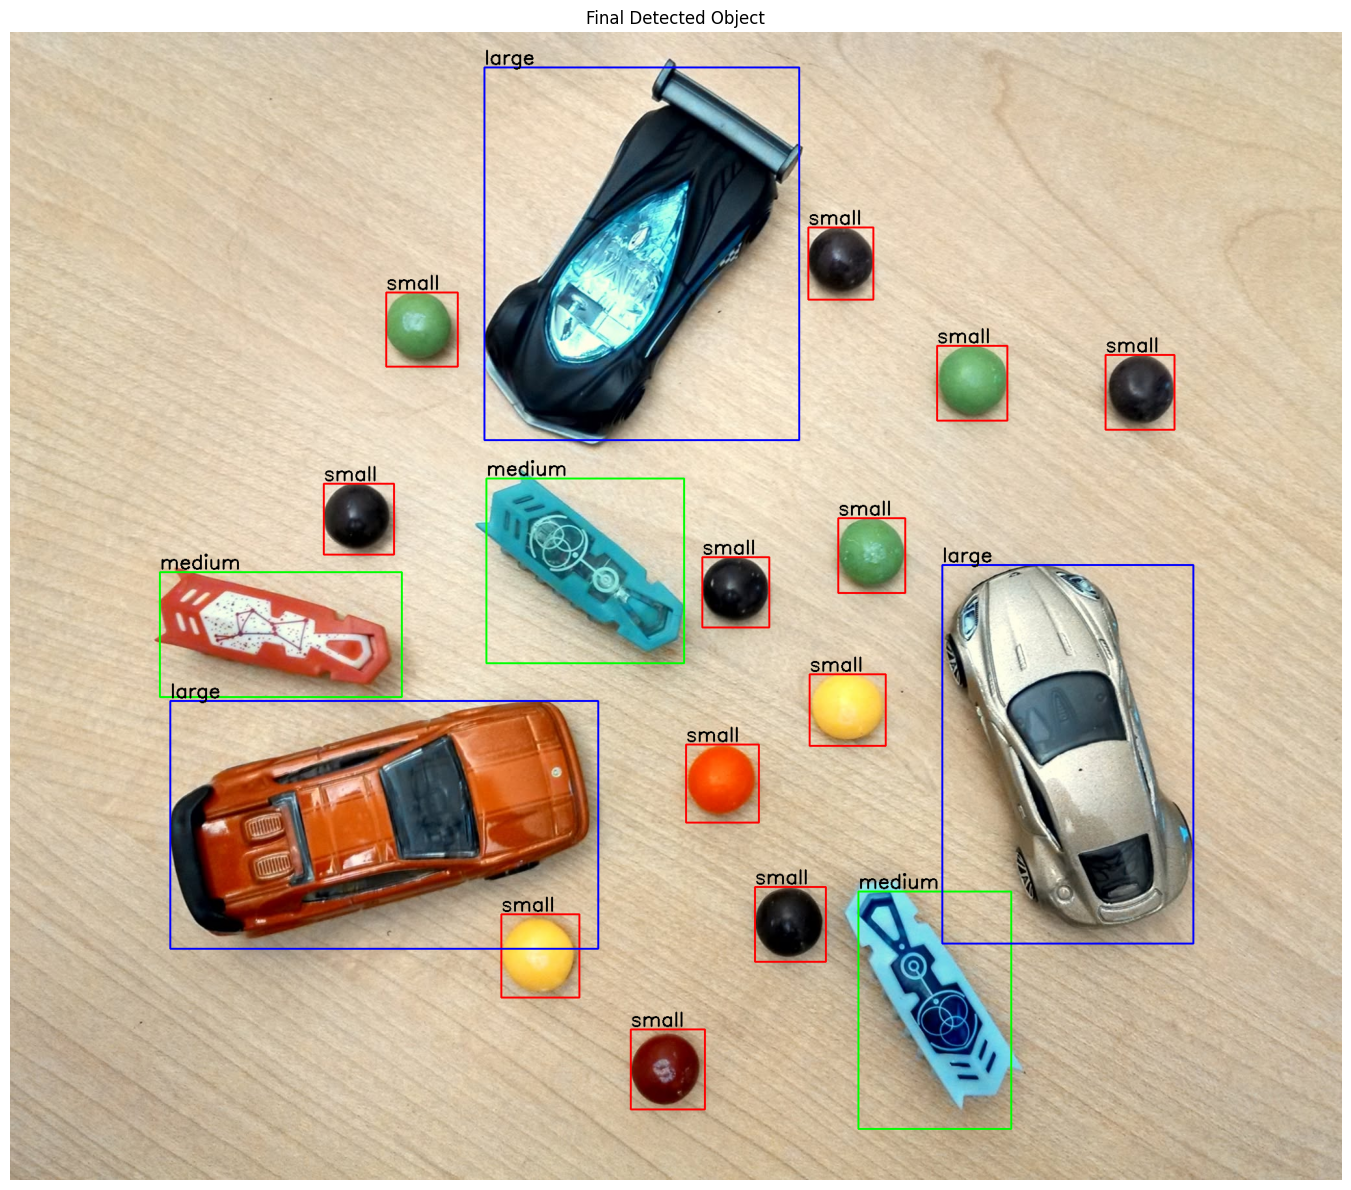

small: 12
medium: 3
large: 3
count: 18


In [77]:
# Classify objects
small, medium, large = [], [], []
for region in regions:
    area = region.area
    if area < 14000:
        small.append(region)
    elif area < 45000:
        medium.append(region)
    else:
        large.append(region)

# Draw boxes on copy of image
output_img = image_rgb.copy()
for region in small:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
    cv2.putText(output_img, 'small', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

for region in medium:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    cv2.putText(output_img, 'medium', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

for region in large:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
    cv2.putText(output_img, 'large', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# Display results side-by-side
fig, axs = plt.subplots(1, 1, figsize=(18, 12))

axs.imshow(output_img)
axs.set_title("Final Detected Object")
axs.axis("off")

plt.tight_layout()
plt.show()

# Display total value
total_value = len(small)  + len(medium)  + len(large) 
print(f"small: {len(small)}")
print(f"medium: {len(medium)}")
print(f"large: {len(large)}")
print(f"count: {total_value}")

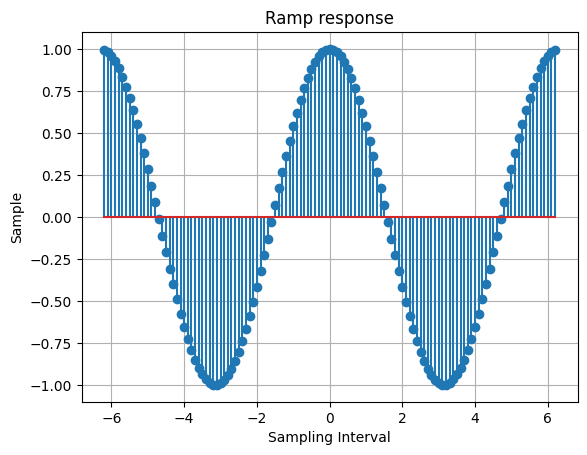

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n = np.arange(-6.2,6.3,0.1) #1 and #2. n = np.arange(-3.1,3.2,0.1), #3 and #4 n = np.arange(-6.2,6.3,0.1)
xn = np.cos(n) #1 np.sin(n) #2 np.cos(n) #3 np.sin(n) #4 np.cos(n) 
plt.stem(n,xn)
plt.title('Ramp response') #Sin wave/ Cosine wave
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

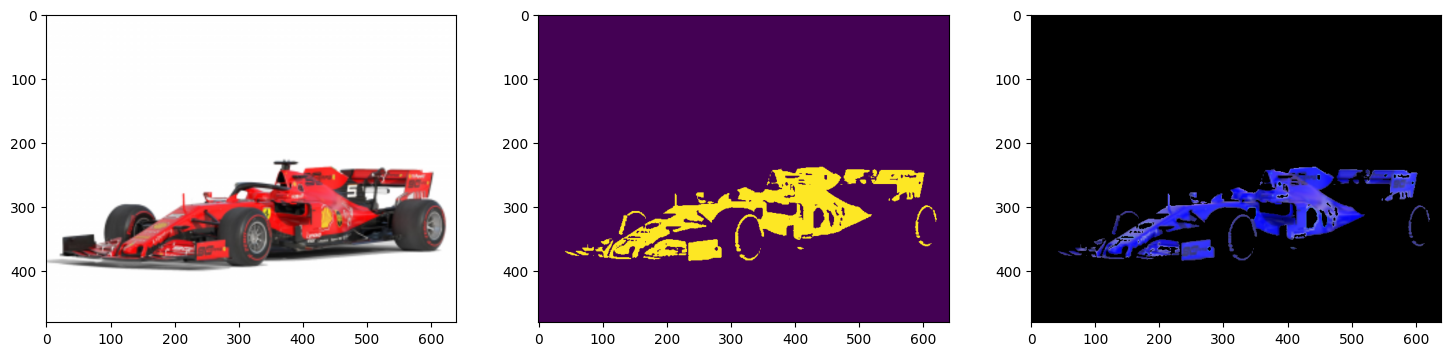

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
image = cv2.imread('myImage.png')
image = cv2.resize(image, (640, 480))  # Resize if needed

# Convert to HSV
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the red color range in HSV
# Red can span across the 0 and 180 boundaries, so we need two ranges
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Create masks
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Combine both masks
red_mask = cv2.bitwise_or(mask1, mask2)

# Apply the mask to the original image
red_result = cv2.bitwise_and(image, image, mask=red_mask)

fig, axs = plt.subplots(1, 3, figsize=(18, 12))
# Display the results
axs[0].imshow(image_rgb)
axs[1].imshow(red_mask)
axs[2].imshow(red_result)
